In [1]:
%cd ..

C:\Users\Brown Research\Documents\vr-exoskeleton


# autoregressive

In [2]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

from vr_exoskeleton import data_utils, gaze_modeling

In [3]:
def load_user(path):
    df = pd.read_csv(path)
    df.drop(columns=['time(100ns)', 'time_stamp(ms)', 'frame'], inplace=True)
    df['eye_in_head_left_x'] = -df['eye_in_head_left_x']
    df['eye_in_head_right_x'] = -df['eye_in_head_right_x']
    df['head_x'] = -df['head_x']  # Counteract C# scale by 'new Vector3(-1, 1, 1)'.
    return df


def load_obj(path):
    df = pd.read_csv(path)
    df.drop(columns=['time(100ns)', 'time_stamp(ms)'], inplace=True)
    return df


users = ['2025040302', '2025041602', '2025042201']
tasks = ['LinearSmoothPursuit', 'ArcSmoothPursuit', 'RapidVisualSearch', 'RapidVisualSearchAvoidance']
n_trials = 3

user_task_paths = dict()
user_task_paths_obj = dict()
for user in users:
    user_task_paths[user] = dict()
    user_task_paths_obj[user] = dict()
    folder_user = os.path.join('..', 'EyeAndNeckTracking', 'Data', 'Users', user)
    for task in tasks:
        user_task_paths[user][task] = list()
        user_task_paths_obj[user][task] = list()
        for trial in range(n_trials):
            fname = f'User{user}_{task}_{trial:d}.csv'
            path = os.path.join(folder_user, fname)
            df = load_user(path)
            user_task_paths[user][task].append(path)

            fname_obj = f'Object{user}_{task}_{trial:d}.csv'
            path_obj = os.path.join(folder_user, fname_obj)
            df_obj = load_obj(path_obj)
            user_task_paths_obj[user][task].append(path_obj)

user_task_paths[users[0]][tasks[0]][0]

'..\\EyeAndNeckTracking\\Data\\Users\\2025040302\\User2025040302_LinearSmoothPursuit_0.csv'

In [4]:
def _vector(df, name, sep, dims):
    cols = [f'{name}{sep}{axis}' for axis in dims]
    return df[cols].to_numpy()


def vector3(df, name, sep='_'):
    return _vector(df, name, sep, ('x', 'y', 'z'))


def vector_rotation(df, name, sep='_'):
    return _vector(df, name, sep, ('x', 'y', 'z', 'w'))

In [5]:
user_to_eye_left_origin = {
    # '2025040302': np.array([ 0.03532695, 0.00364703, -0.02478334]),
    # '2025041602': np.array([ 0.031268, -0.00073946, -0.02363204]),
    # '2025042201': np.array([ 0.03211912, -0.00299114, -0.02772827])
    '2025040302': np.array([-0.03532695, 0.00364703, -0.02478334]),
    '2025041602': np.array([-0.031268, -0.00073946, -0.02363204]),
    '2025042201': np.array([-0.03211912, -0.00299114, -0.02772827])
}
user_to_eye_right_origin = {
    # '2025040302': np.array([-0.030932, -0.00060822, -0.02428921]),
    # '2025041602': np.array([-0.03364768, -0.00047236, -0.02439187]),
    # '2025042201': np.array([-0.0298891, 0.00264301, -0.02789513])
    '2025040302': np.array([ 0.030932, -0.00060822, -0.02428921]),
    '2025041602': np.array([ 0.03364768, -0.00047236, -0.02439187]),
    '2025042201': np.array([ 0.0298891, 0.00264301, -0.02789513])
}

In [6]:
def error_angle(v1, v2):
    return np.arccos(np.sum(v1 * v2))


def gaze_radius_bounded(g):
    # solve (x^2/0.5) + ((y+0.1)^2)/0.5 = 1
    norm_z = np.sqrt(g[0] ** 2 + (g[1] + 0.1) ** 2)
    m = min(0.5, norm_z) / norm_z
    g_b = g.copy()
    g_b[0] = m * g_b[0]
    g_b[1] = m * (g_b[1] + 0.1) - 0.1
    g_b[2] = max(0.825, g_b[2])
    return g_b / np.linalg.norm(g_b)


def autoregressive(model, downsampling_rate=1):
    i_print = 0
    # TODO: Add focal-point tracking instead of object tracking.
    # TODO: Add stochasticity to either focal point.
    user_task_losses = dict()
    user_task_trajs = dict()
    for user in users:
        user_task_losses[user] = dict()
        user_task_trajs[user] = dict()
        for task in tasks[:2]:
            # Begin trial.
            trial_losses = list()
            trajs = list()
            paths = user_task_paths[user][task]
            paths_obj = user_task_paths_obj[user][task]
            for path, path_obj in zip(paths, paths_obj):
                df = load_user(path)
                df_obj = load_obj(path_obj)
                X_head_origin = vector3(df, 'head_origin')
                X_obj = vector3(df_obj, 'object1', sep='.')
                X_gaze_l = vector3(df, 'eye_in_head_left')
                X_gaze_r = vector3(df, 'eye_in_head_right')
                Y_head = vector3(df, 'head')
                # break

                for shift in range(downsampling_rate):
                    sel = slice(shift, None, downsampling_rate)
                    X_head_origin_ = X_head_origin[sel]
                    X_obj_ = X_obj[sel]
                    X_gaze_l_ = X_gaze_l[sel]
                    X_gaze_r_ = X_gaze_r[sel]
                    Y_head_ = Y_head[sel]
                    
                    kwargs = dict()
                    losses = list()
                    traj = list()
                    head = np.array([0, 0, 1])
                    eye_left_origin_init = user_to_eye_left_origin[user]
                    eye_right_origin_init = user_to_eye_right_origin[user]
                    for t, (x_head_origin, x_obj, y_head) in enumerate(zip(X_head_origin_, X_obj_, Y_head_)):
                        fx, fy, fz = head
                        q = Rotation.from_rotvec([-np.arctan(fy / fz), np.arctan(fx / fz), 0.])
                        
                        eye_left_origin = q.apply(eye_left_origin_init) + x_head_origin
                        gaze_l = x_obj - eye_left_origin
                        gaze_l /= np.linalg.norm(gaze_l)
                        gaze_l = q.apply(gaze_l, inverse=True)
                        gaze_l = gaze_radius_bounded(gaze_l)
                        
                        eye_right_origin = q.apply(eye_right_origin_init) + x_head_origin
                        gaze_r = x_obj - eye_right_origin
                        gaze_r /= np.linalg.norm(gaze_r)
                        gaze_r = q.apply(gaze_r, inverse=True)
                        gaze_r = gaze_radius_bounded(gaze_r)

                        x = np.concatenate([gaze_l, gaze_r, head])
                        X = x[np.newaxis, :]
                        with torch.no_grad():
                            X_ = torch.tensor(X, dtype=torch.float32)
                            Y_hat = model(X_, **kwargs)
                            if isinstance(Y_hat, tuple):
                                Y_hat, hn, cn = Y_hat
                                kwargs['h0'] = hn
                                kwargs['c0'] = cn
                        y_hat = Y_hat[0].numpy()
                        # print(y)

                        delta = Rotation.from_rotvec([-y_hat[0], y_hat[1], 0.])
                        head = delta.apply(head)

                        # loss = np.linalg.norm(y_head - head)
                        loss = error_angle(y_head, head)
                        # print(y_head, head, loss)
                        losses.append(loss)

                        traj.append(x)
                        # break

                    trial_losses.append(sum(losses) / len(losses))
                    trajs.append((np.array(traj), Y_head_, X_head_origin_, X_obj_, X_gaze_l_, X_gaze_r_))
                    # break

            user_task_losses[user][task] = trial_losses
            user_task_trajs[user][task] = trajs
            
    return user_task_losses, user_task_trajs

In [7]:
def plot_traj_3d(traj, title=None):
    plt.close()
    fig = plt.figure(figsize=(12, 3.6))
    for i, dim in enumerate(['x', 'y', 'z']):
        plt.plot(range(len(traj)), traj[:, i], label=dim)
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()


def plot_trial(trajs, model_name=None, show_constants=False):
    suffix = f' ({model_name})' if model_name is not None else ''

    if show_constants:
        plot_traj_3d(trajs[3], title='Object position')
        plot_traj_3d(trajs[1], title='True head direction')
    plot_traj_3d(trajs[0][:, 6:9], title='Predicted & followed head direction' + suffix)
    if show_constants:
        plot_traj_3d(trajs[4], title='True left eye direction in head')
    plot_traj_3d(trajs[0][:, 0:3], title='Left eye direction in head' + suffix)
    if show_constants:
        plot_traj_3d(trajs[5], title='True right eye direction in head')
    plot_traj_3d(trajs[0][:, 3:6], title='Right eye direction in head' + suffix)


In [8]:
def load_weights(model, path_weights):
    weights = torch.load(path_weights, weights_only=True)
    model.load_state_dict(weights)

### MLP

In [9]:
mlp = gaze_modeling.GazeMLP()
# load_weights(mlp, 'output/runs/1745426038_mlp_90hz-angle-h_s49/val_best.pth')  # Negated head_x; true head 'x' is negated.
# load_weights(mlp, 'output/runs/1748387184_mlp_90hz-angle-h_s50/val_best.pth')  # ; predicted head 'x' is pushed to `1`.
load_weights(mlp, 'output/runs/1748389086_mlp_90hz-angle-h_s50/val_best.pth')  # Negated gaze_[lr]_x; head 'y' seems to be negated.

user_task_losses_mlp, user_task_trajs_mlp = autoregressive(mlp)
user_task_losses_mlp

{'2025040302': {'LinearSmoothPursuit': [0.12468583185588211,
   0.11807589692034473,
   0.14120058175750183],
  'ArcSmoothPursuit': [0.6822220448837478,
   0.8618979459000992,
   0.9976034581087719]},
 '2025041602': {'LinearSmoothPursuit': [0.2743557593859791,
   0.3337651738805435,
   0.27087218158408216],
  'ArcSmoothPursuit': [1.066213568271045,
   0.8474583067012158,
   1.1176747682345445]},
 '2025042201': {'LinearSmoothPursuit': [0.19582016677564595,
   0.19652118439792748,
   0.20056995323810625],
  'ArcSmoothPursuit': [0.1940026687510552,
   0.2162062021687043,
   0.17290933051941984]}}

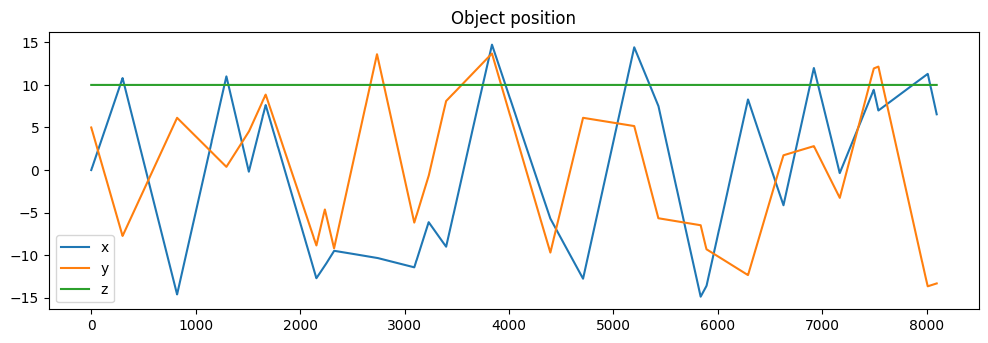

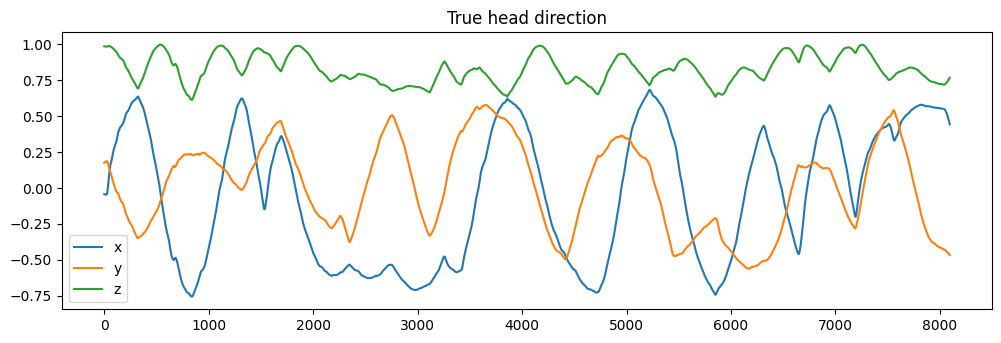

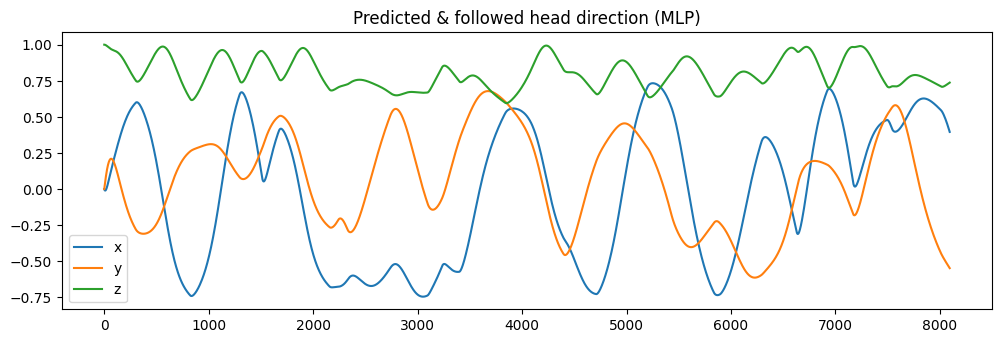

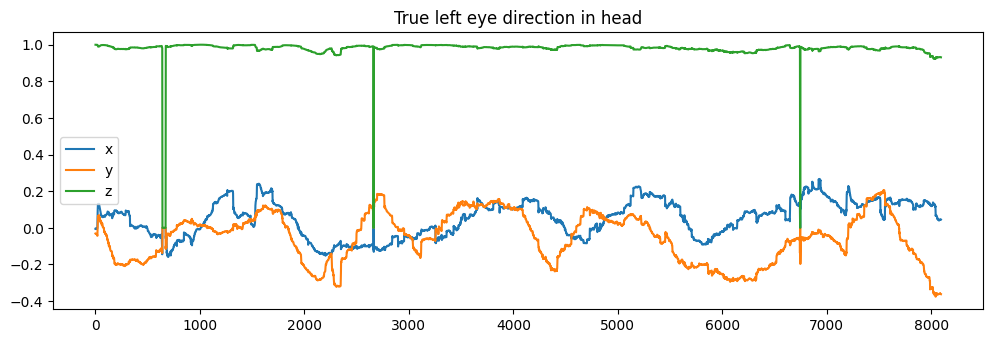

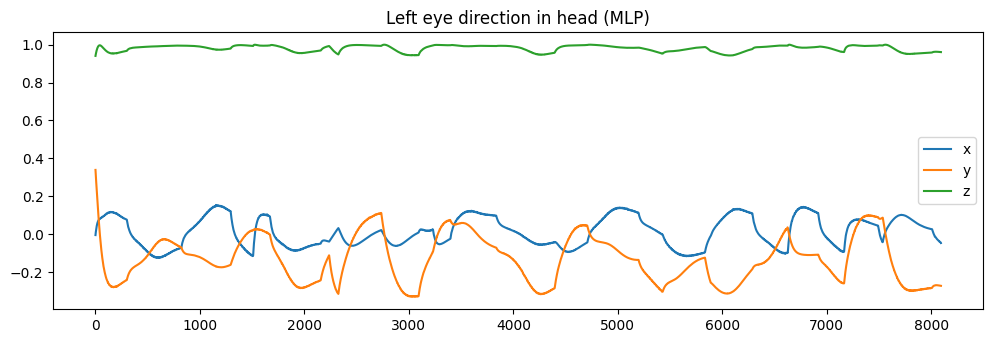

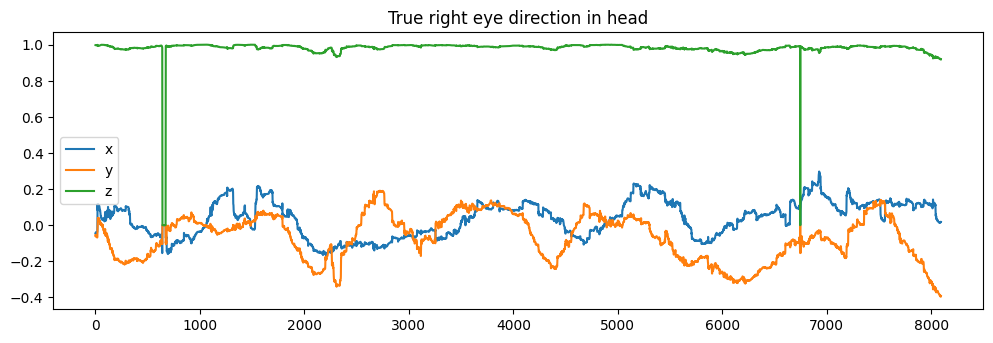

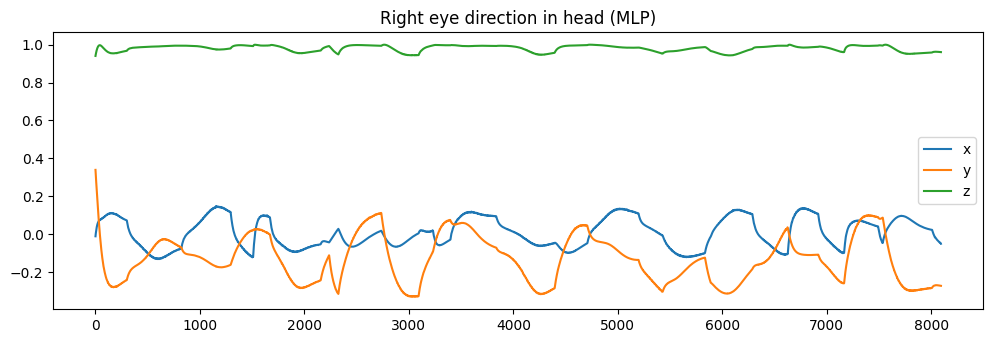

In [10]:
plot_trial(user_task_trajs_mlp[users[0]][tasks[0]][0], model_name='MLP', show_constants=True)

### MLP-H16_16

In [11]:
mlp2 = gaze_modeling.GazeMLP(hidden_sizes=[16, 16])
load_weights(mlp2, 'output/runs/1748536703_mlp_90hz-angle-h16_16_s50/val_best.pth')

user_task_losses_mlp2, user_task_trajs_mlp2 = autoregressive(mlp2)
user_task_losses_mlp2

{'2025040302': {'LinearSmoothPursuit': [0.16817476008946247,
   0.1823530508313502,
   0.13800743933137227],
  'ArcSmoothPursuit': [0.6601697001214354,
   0.8265998490101114,
   0.9436559237619063]},
 '2025041602': {'LinearSmoothPursuit': [0.2865189317022761,
   0.3376457917163439,
   0.2992335232081101],
  'ArcSmoothPursuit': [1.114582445106057,
   0.9087696529926274,
   1.185288946314889]},
 '2025042201': {'LinearSmoothPursuit': [0.19409285734540843,
   0.2090962199406523,
   0.2056479641140421],
  'ArcSmoothPursuit': [0.22221547649655912,
   0.40639933635088044,
   0.21326520108198463]}}

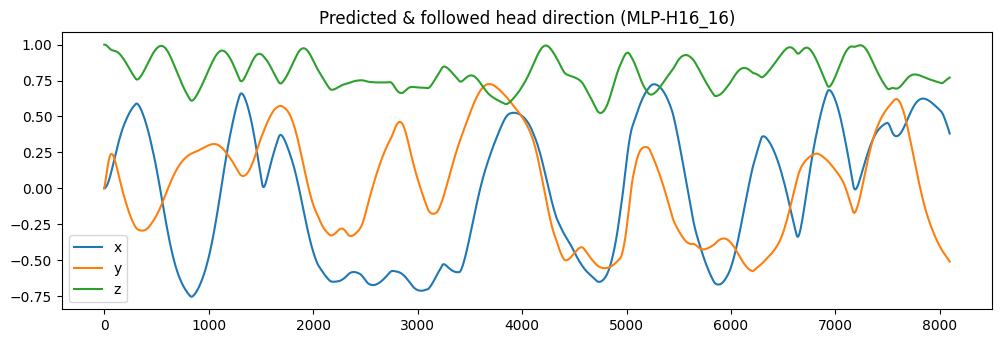

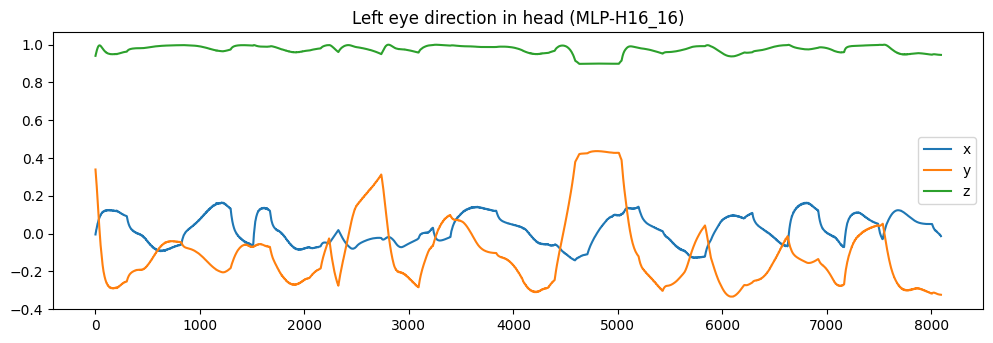

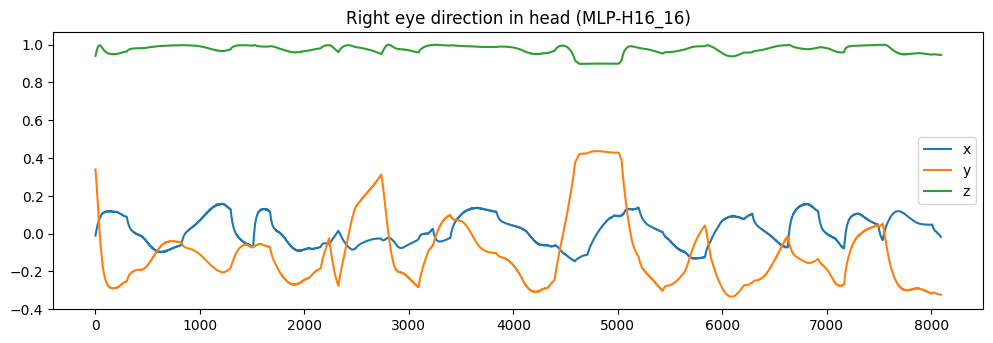

In [12]:
plot_trial(user_task_trajs_mlp2[users[0]][tasks[0]][0], model_name='MLP-H16_16')

In [13]:
user_task_trajs_mlp2[users[0]][tasks[0]][0][0][4900, 0:3]

array([0.07360915, 0.43104258, 0.89932418])

In [14]:
np.argmin(user_task_trajs_mlp2[users[0]][tasks[0]][0][4][:, 2])

640

In [15]:
user_task_trajs_mlp2[users[0]][tasks[0]][0][4][640]

array([-0.,  0.,  0.])

### LSTM

In [16]:
lstm = gaze_modeling.GazeLSTM()
load_weights(lstm, 'output/runs/1748539949_lstm_45hz-angle-h_s50/val_best.pth')

user_task_losses_lstm, user_task_trajs_lstm = autoregressive(lstm, downsampling_rate=2)
user_task_losses_lstm

{'2025040302': {'LinearSmoothPursuit': [0.10663260608760289,
   0.10660187512072443,
   0.09788996175871024,
   0.09790697783562556,
   0.13607586131083552,
   0.13604110983345244],
  'ArcSmoothPursuit': [0.6848107309118509,
   0.6848308763499741,
   0.8662123685939356,
   0.8661841096662501,
   0.9898381471600103,
   0.9899743440492728]},
 '2025041602': {'LinearSmoothPursuit': [0.24488093627748989,
   0.2448592066639175,
   0.3008011251552109,
   0.3007866444107921,
   0.24804115264632662,
   0.24795820485344114],
  'ArcSmoothPursuit': [1.0409662206696983,
   1.04093737863624,
   0.8223313630193763,
   0.8223242502445773,
   1.0904977364471606,
   1.0905284152934553]},
 '2025042201': {'LinearSmoothPursuit': [0.1712110169679403,
   0.17120144018394162,
   0.18277841476587525,
   0.18278565578012362,
   0.18565444425456937,
   0.18563907943981742],
  'ArcSmoothPursuit': [0.18107314229010285,
   0.1810869568375306,
   0.2039304663409567,
   0.203946893805469,
   0.1628311823199837,
   0.

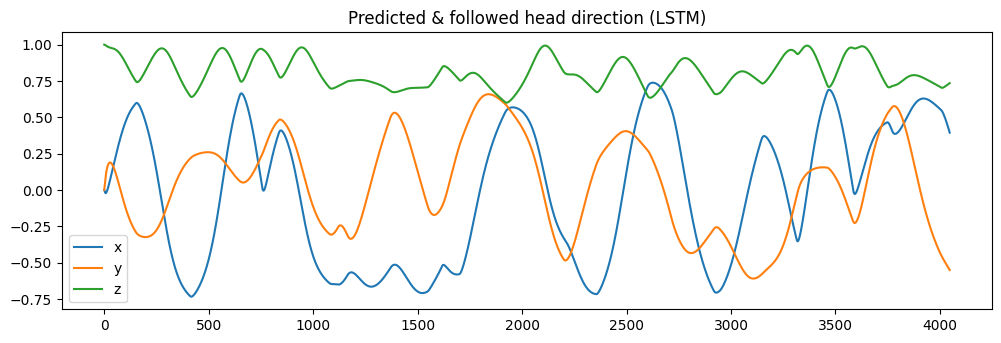

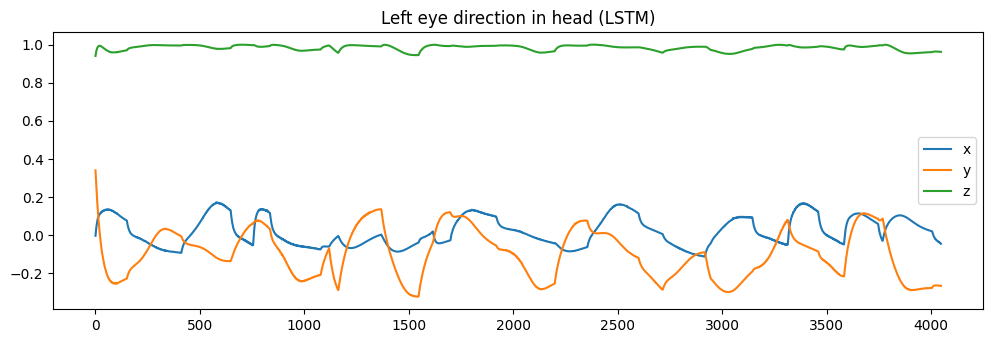

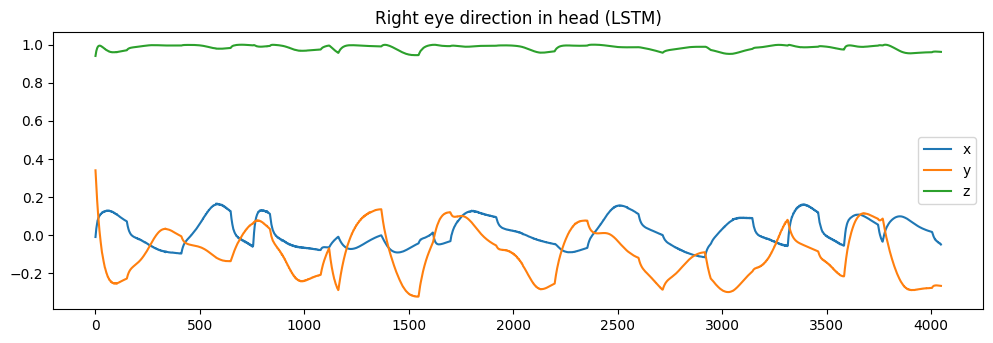

In [17]:
plot_trial(user_task_trajs_lstm[users[0]][tasks[0]][0], model_name='LSTM')

### LSTM-H2

In [18]:
lstm2 = gaze_modeling.GazeLSTM(hidden_sizes=[2])
load_weights(lstm2, 'output/runs/1748541737_lstm_45hz-angle-h2_s50/val_best.pth')

user_task_losses_lstm2, user_task_trajs_lstm2 = autoregressive(lstm2, downsampling_rate=2)
user_task_losses_lstm2

{'2025040302': {'LinearSmoothPursuit': [0.12620290530785536,
   0.12617410483027697,
   0.11431296896920852,
   0.11430628718851829,
   0.12588871666329976,
   0.12585126743292535],
  'ArcSmoothPursuit': [0.6621475091633424,
   0.6621746923332945,
   0.8296411339598309,
   0.829612936069031,
   0.951869752476965,
   0.9520019290982772]},
 '2025041602': {'LinearSmoothPursuit': [0.28101027781588755,
   0.28101088401301905,
   0.3313367945208055,
   0.3312912345204843,
   0.2725576285545071,
   0.2724505164617782],
  'ArcSmoothPursuit': [1.087306140567515,
   1.0872960894220178,
   0.8780053491703457,
   0.8780225572340674,
   1.1518434524822954,
   1.1518981284453444]},
 '2025042201': {'LinearSmoothPursuit': [0.19609221888577275,
   0.19608730412804037,
   0.20279026066402506,
   0.2028067929410816,
   0.2085703685665807,
   0.20853947033110182],
  'ArcSmoothPursuit': [0.20289060984400023,
   0.2029093395245007,
   0.20740620690008227,
   0.20744759964769474,
   0.18508105022986987,
   0

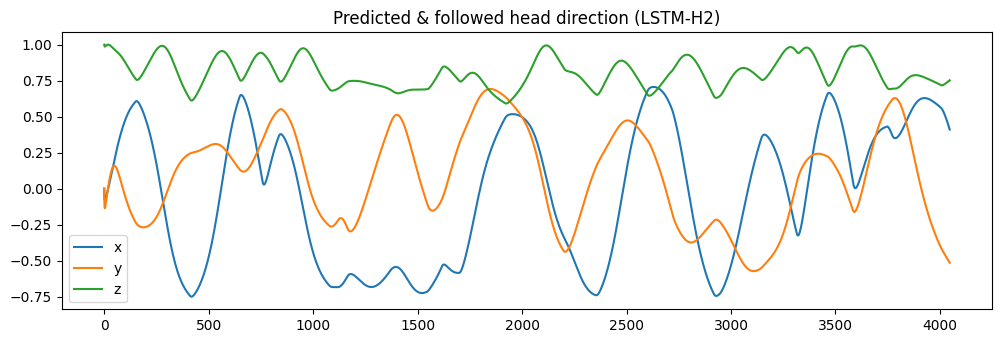

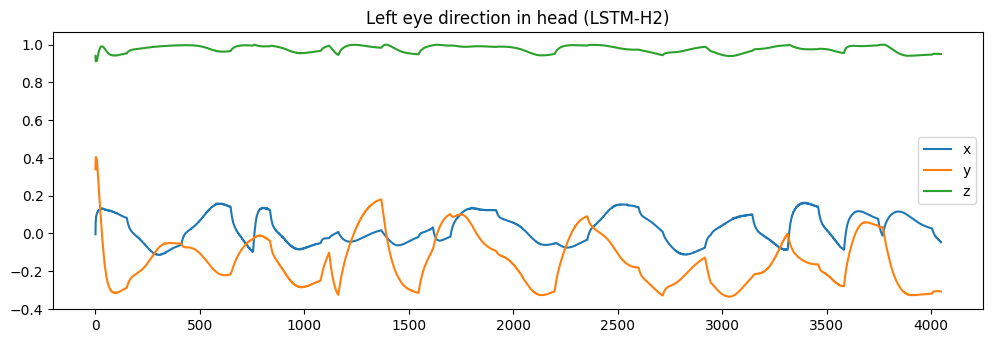

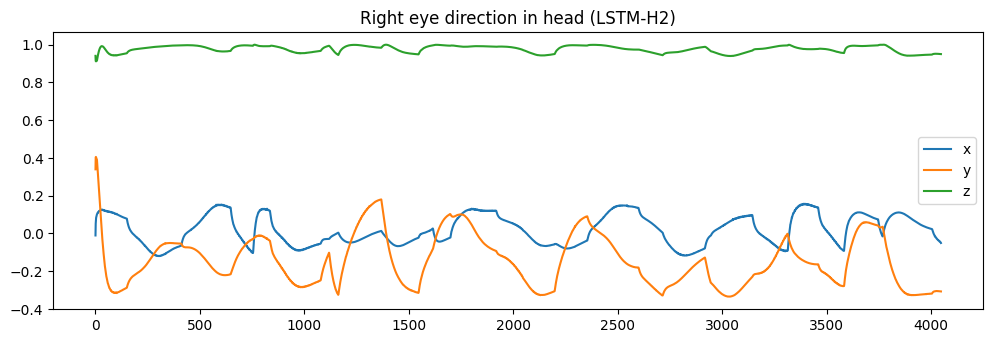

In [19]:
plot_trial(user_task_trajs_lstm2[users[0]][tasks[0]][0], model_name='LSTM-H2')

### LSTM-H16

In [20]:
lstm3 = gaze_modeling.GazeLSTM(hidden_sizes=[16])
load_weights(lstm3, 'output/runs/1748542727_lstm_45hz-angle-h16_s50/val_best.pth')

user_task_losses_lstm3, user_task_trajs_lstm3 = autoregressive(lstm3, downsampling_rate=2)
user_task_losses_lstm3

{'2025040302': {'LinearSmoothPursuit': [0.4705331578825258,
   0.4715220052444803,
   0.19649693030321447,
   0.19572621014805094,
   1.1781560529469854,
   1.179981067793325],
  'ArcSmoothPursuit': [0.6497179603255199,
   0.6497423577010196,
   0.8090713588536935,
   0.809041076416172,
   0.9277618991017498,
   0.927878509927277]},
 '2025041602': {'LinearSmoothPursuit': [1.0341517855051343,
   1.033979887727144,
   1.1870015237384248,
   1.1868636766715213,
   0.30317706265943956,
   0.3031150656141672],
  'ArcSmoothPursuit': [0.908219039199378,
   0.9081399606152383,
   0.688171152226903,
   0.6880953368184878,
   0.6146550250637562,
   0.6145471175631811]},
 '2025042201': {'LinearSmoothPursuit': [0.7827105160737294,
   0.7828492424725577,
   0.27648604553989864,
   0.2751835408704112,
   0.2293830949019343,
   0.22927400511910576],
  'ArcSmoothPursuit': [1.454270145346539,
   1.454696531227855,
   1.181366222322272,
   1.1841052741525648,
   1.2400401054869559,
   1.2401076486799298

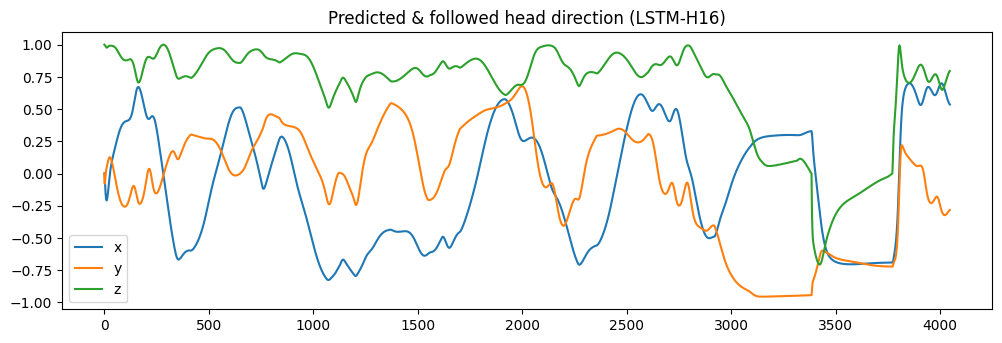

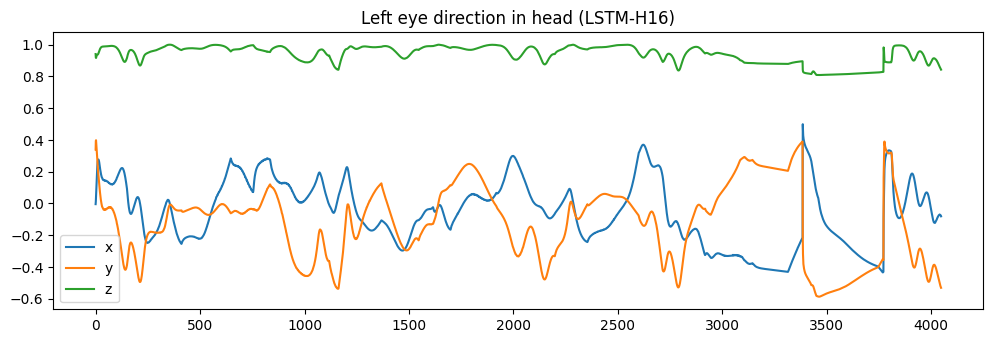

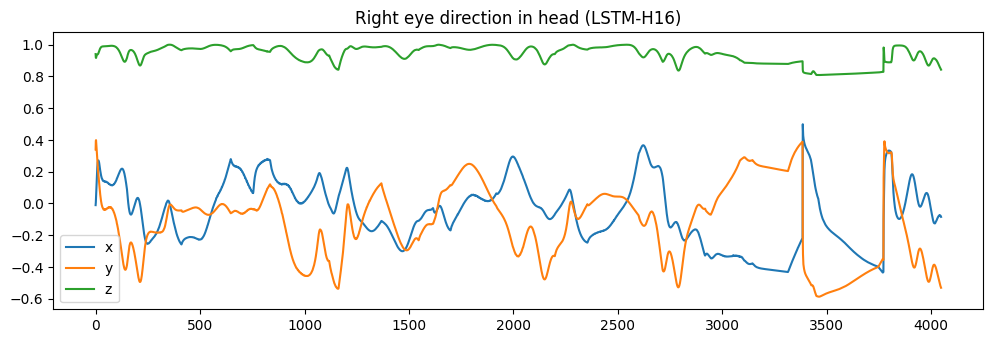

In [21]:
plot_trial(user_task_trajs_lstm3[users[0]][tasks[0]][0], model_name='LSTM-H16')

### LSTM-H128

In [22]:
lstm4 = gaze_modeling.GazeLSTM(hidden_sizes=[128])
load_weights(lstm4, 'output/runs/1748544043_lstm_45hz-angle-h128_s50/val_best.pth')

user_task_losses_lstm4, user_task_trajs_lstm4 = autoregressive(lstm4, downsampling_rate=2)
user_task_losses_lstm4

{'2025040302': {'LinearSmoothPursuit': [2.1974205251017787,
   2.196846416492963,
   2.213604680934643,
   2.2150100834821926,
   2.1461421948662833,
   2.145726516055346],
  'ArcSmoothPursuit': [2.121584558091495,
   2.1225596162706606,
   2.1699229797143387,
   2.172997727435789,
   2.2344168445922374,
   2.2334416722488966]},
 '2025041602': {'LinearSmoothPursuit': [2.177221286799635,
   2.178367718690945,
   2.1841523121915896,
   2.1847945458008757,
   2.1174535264319725,
   2.1180918761624192],
  'ArcSmoothPursuit': [1.9436111579881692,
   1.9436110237727293,
   1.966202914922667,
   1.9665171467675038,
   1.8378648250306022,
   1.8379090936045102]},
 '2025042201': {'LinearSmoothPursuit': [2.1336302777248073,
   2.1339829326960484,
   2.1506429890146017,
   2.148987854758415,
   2.179874794627275,
   2.1804741689821903],
  'ArcSmoothPursuit': [2.07768845417058,
   2.077266758231812,
   2.1818144219320392,
   2.1803929865747973,
   1.9811294624740576,
   1.9806625224392653]}}

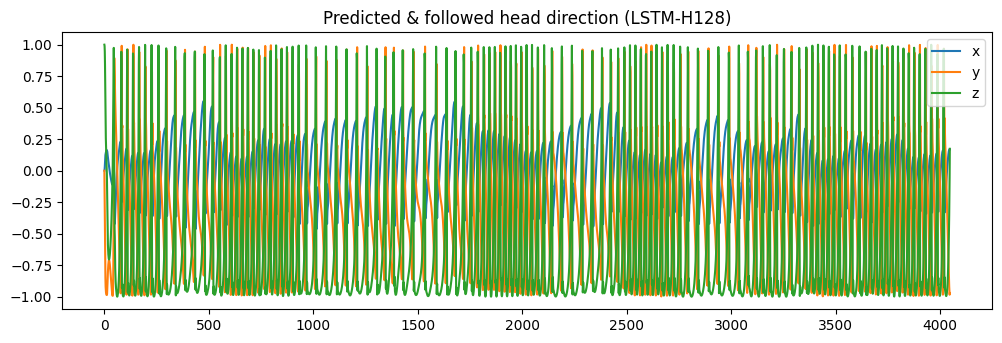

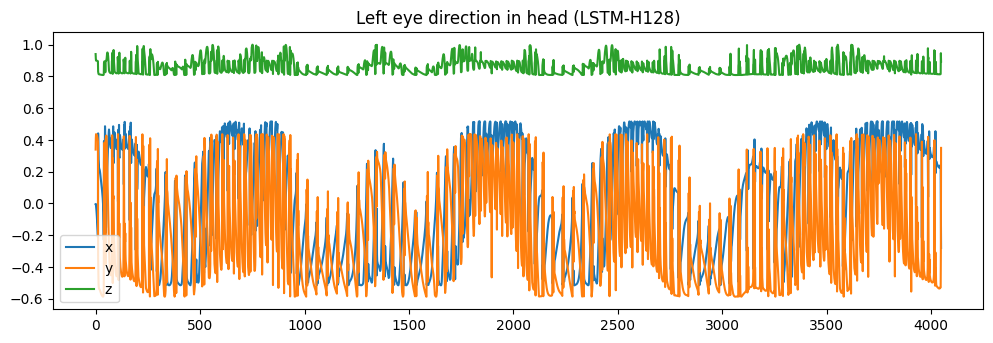

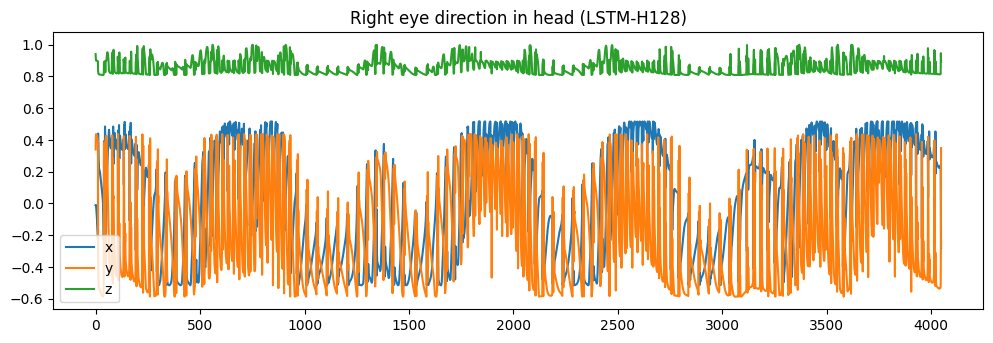

In [23]:
plot_trial(user_task_trajs_lstm4[users[0]][tasks[0]][0], model_name='LSTM-H128')

### Vector (baseline)

In [24]:
vector = gaze_modeling.GazeVectorBaseline()

user_task_losses_vector, user_task_trajs_vector = autoregressive(vector)
user_task_losses_vector

{'2025040302': {'LinearSmoothPursuit': [0.13388687126001955,
   0.122080109180069,
   0.1759749534242843],
  'ArcSmoothPursuit': [0.7133609189097733,
   0.9063753092735132,
   1.0524058115361945]},
 '2025041602': {'LinearSmoothPursuit': [0.2802177905519967,
   0.33234093947236054,
   0.2790225015269793],
  'ArcSmoothPursuit': [1.1159570452413035,
   0.8976852943708024,
   1.1706027905241694]},
 '2025042201': {'LinearSmoothPursuit': [0.13161709615264064,
   0.14589574404171768,
   0.15965142239049618],
  'ArcSmoothPursuit': [0.1897852312904642,
   0.2295422336234411,
   0.13142233944678877]}}

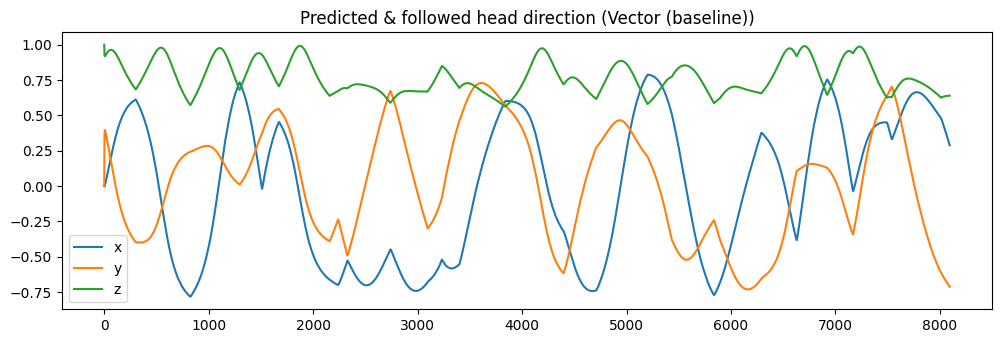

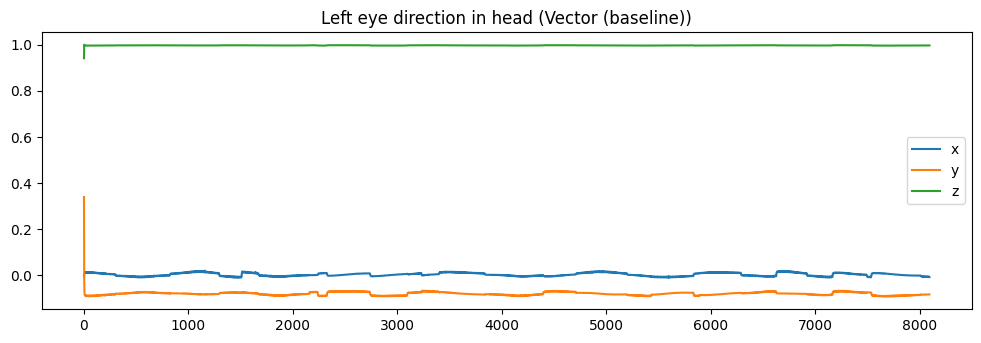

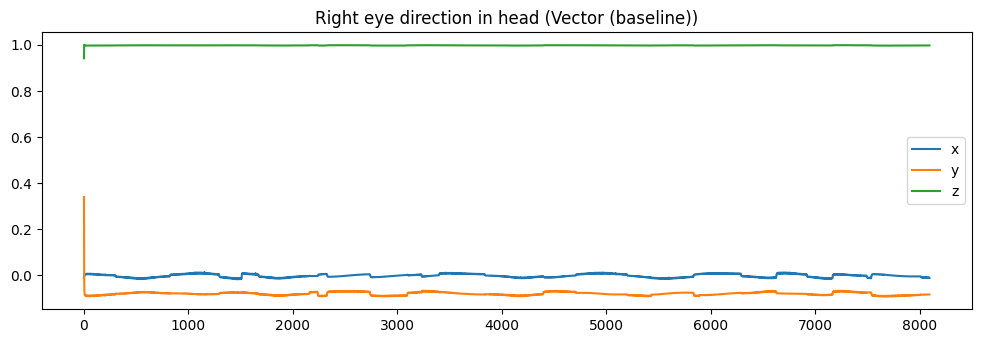

In [25]:
plot_trial(user_task_trajs_vector[users[0]][tasks[0]][0], model_name='Vector (baseline)')

### Vector-P

In [26]:
vectorp = gaze_modeling.GazeVectorParameterized()
load_weights(vectorp, 'output/runs/1748557709_vector-p_s50/val_best.pth')

user_task_losses_vectorp, user_task_trajs_vectorp = autoregressive(vectorp)
user_task_losses_vectorp

{'2025040302': {'LinearSmoothPursuit': [0.18169926074116888,
   0.1694402637547166,
   0.2158154553798795],
  'ArcSmoothPursuit': [0.6957771404738232,
   0.8825289972156992,
   1.0271779455307526]},
 '2025041602': {'LinearSmoothPursuit': [0.30659895896699363,
   0.3684019532333914,
   0.31676862294756836],
  'ArcSmoothPursuit': [1.1480161796195407,
   0.9340746162927162,
   1.2103863379490913]},
 '2025042201': {'LinearSmoothPursuit': [0.23533341406416203,
   0.2479481187844922,
   0.25234325579515554],
  'ArcSmoothPursuit': [0.24591459064538446,
   0.29578135388651255,
   0.20860775986487282]}}

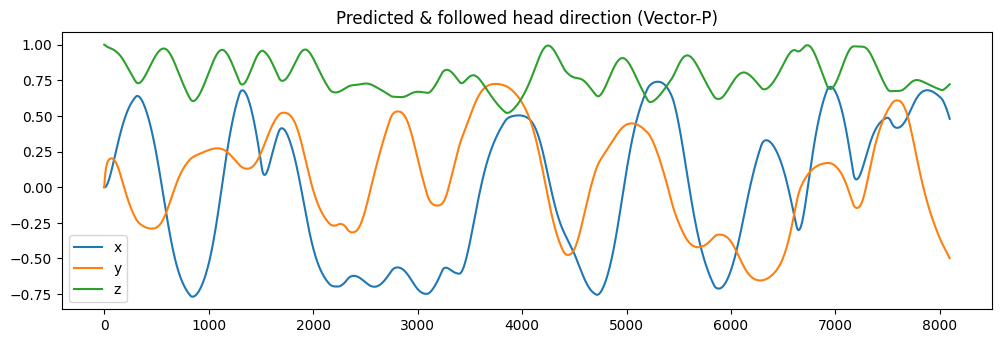

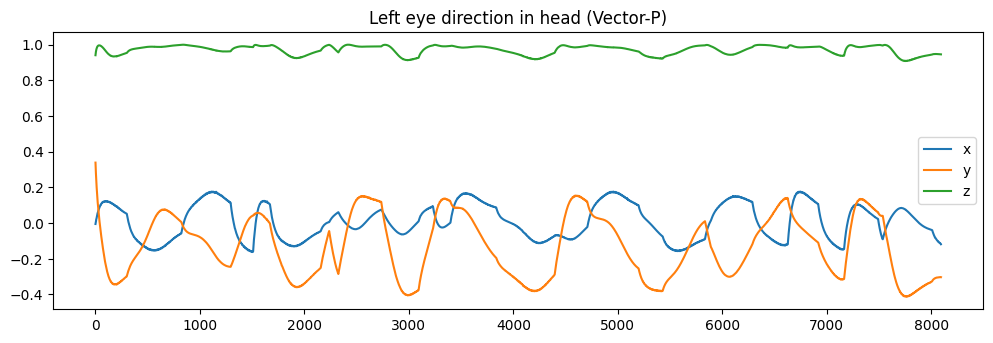

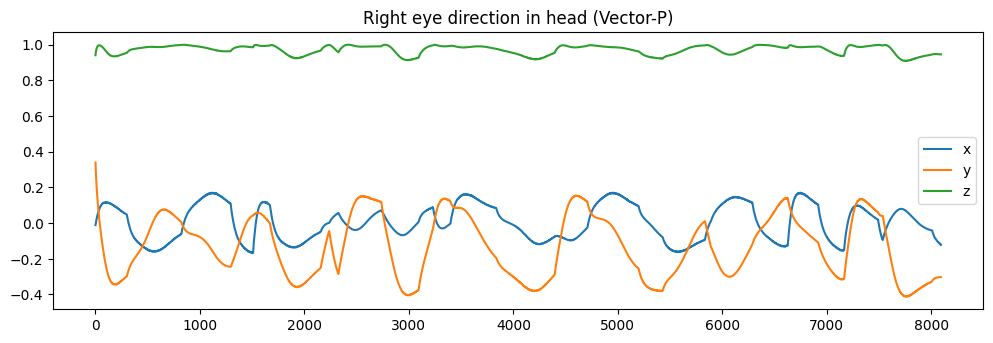

In [27]:
plot_trial(user_task_trajs_vectorp[users[0]][tasks[0]][0], model_name='Vector-P')

## Comparison

In [28]:
models = [mlp, mlp2, lstm, lstm2, lstm3, lstm4, vector, vectorp]
model_names = ['MLP', 'MLP-H16_16', 'LSTM', 'LSTM-H2', 'LSTM-H16', 'LSTM-H128', 'Vector (baseline)', 'Vector-P']
model_user_task_losses = [
    user_task_losses_mlp, user_task_losses_mlp2,
    user_task_losses_lstm, user_task_losses_lstm2,
    user_task_losses_lstm3, user_task_losses_lstm4,
    user_task_losses_vector, user_task_losses_vectorp
]

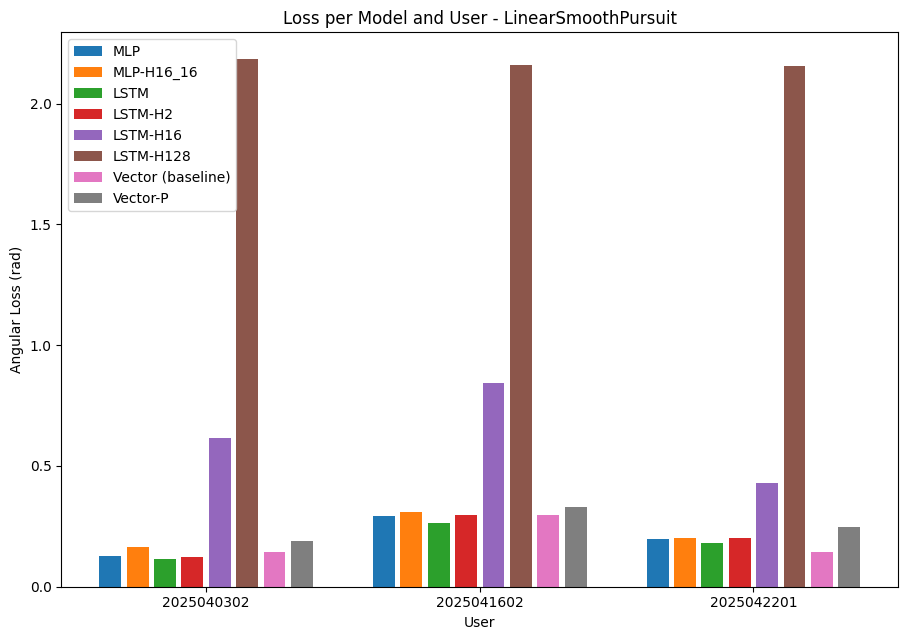

In [29]:
gap = 0.1
w = (1 - gap) / (len(model_names) + 1)
colors = [f'C{i:d}' for i in range(len(model_names))]

xs = [[start + (gap / 2) + (w * (i + 1)) for i in range(len(model_names))]
      for start in range(len(users))]

plt.figure(figsize=(10.8, 7.2))
for i in range(len(users)):
    scores = [sum(user_task_losses[users[i]][tasks[0]]) / len(user_task_losses[users[i]][tasks[0]]) for user_task_losses in model_user_task_losses]
    plt.bar(xs[i], scores, w - 0.02, color=colors, label=model_names if i == 0 else None)
plt.title(f'Loss per Model and User - {tasks[0]}')
plt.ylabel('Angular Loss (rad)')
plt.xlabel('User')
plt.xticks([0.5 + i for i in range(len(users))], users)
plt.legend()
plt.show()

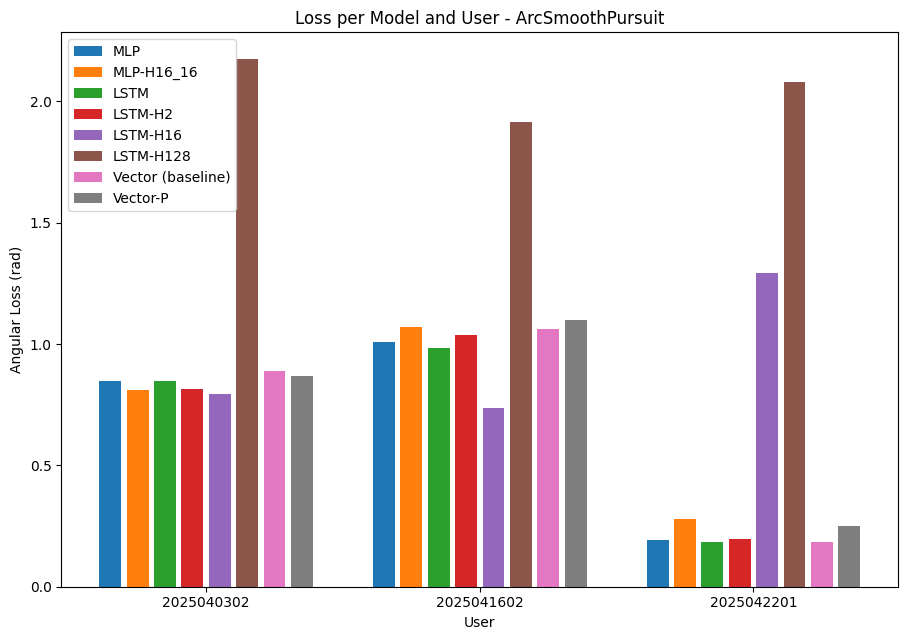

In [30]:
gap = 0.1
w = (1 - gap) / (len(model_names) + 1)
colors = [f'C{i:d}' for i in range(len(model_names))]

xs = [[start + (gap / 2) + (w * (i + 1)) for i in range(len(model_names))]
      for start in range(len(users))]

plt.figure(figsize=(10.8, 7.2))
for i in range(len(users)):
    scores = [sum(user_task_losses[users[i]][tasks[1]]) / len(user_task_losses[users[i]][tasks[0]]) for user_task_losses in model_user_task_losses]
    plt.bar(xs[i], scores, w - 0.02, color=colors, label=model_names if i == 0 else None)
plt.title(f'Loss per Model and User - {tasks[1]}')
plt.ylabel('Angular Loss (rad)')
plt.xlabel('User')
plt.xticks([0.5 + i for i in range(len(users))], users)
plt.legend()
plt.show()